# Setting up Data

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import os
import csv

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Simulating Early Data for Instruments Lacking

0 ADA.csv
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2017-11-09  0.025160  0.035060  0.025006  0.032053   0.032053  18716200
2017-11-10  0.032219  0.033348  0.026451  0.027119   0.027119   6766780
2017-11-11  0.026891  0.029659  0.025684  0.027437   0.027437   5532220
2017-11-12  0.027480  0.027952  0.022591  0.023977   0.023977   7280250
2017-11-13  0.024364  0.026300  0.023495  0.025808   0.025808   4419440
1 AVAX.csv
                Open      High       Low     Close Adj Close           Volume
Date                                                                         
2017-11-09   1.30577  3.768177  1.090219  1.600301  2.052324  17195729.592314
2017-11-10  1.566733  3.614345  1.095938  1.358677  1.736404   6270368.199174
2017-11-11   1.32571  3.186724  1.049573  1.336868  1.756765   5122396.560902
2017-11-12  1.304646  2.940181  0.917094  1.169522  1.535225   6678557.711719
2017-11

C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

                Open      High       Low     Close Adj Close          Volume
Date                                                                        
2017-11-09  0.001491  0.001892   0.00144  0.001771  0.002066  3230891.785765
2017-11-10  0.001789  0.001814  0.001448  0.001503  0.001748  1178134.431556
2017-11-11  0.001514    0.0016  0.001386  0.001479  0.001768   962442.964877
2017-11-12   0.00149  0.001476  0.001211  0.001294  0.001545  1254828.830362
2017-11-13  0.001321  0.001403  0.001264  0.001394  0.001663   774826.229789
5 SOL.csv
                Open      High       Low     Close Adj Close           Volume
Date                                                                         
2017-11-09  0.500877  1.022507   0.46029  0.749254  0.917782  14987890.633816
2017-11-10  0.600979  0.980764  0.462705  0.636127  0.776506   5465286.732875
2017-11-11  0.508526  0.864728  0.443129  0.625916  0.785611   4464708.462975
2017-11-12  0.500446  0.797828  0.387197  0.547565   0.68654 

C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

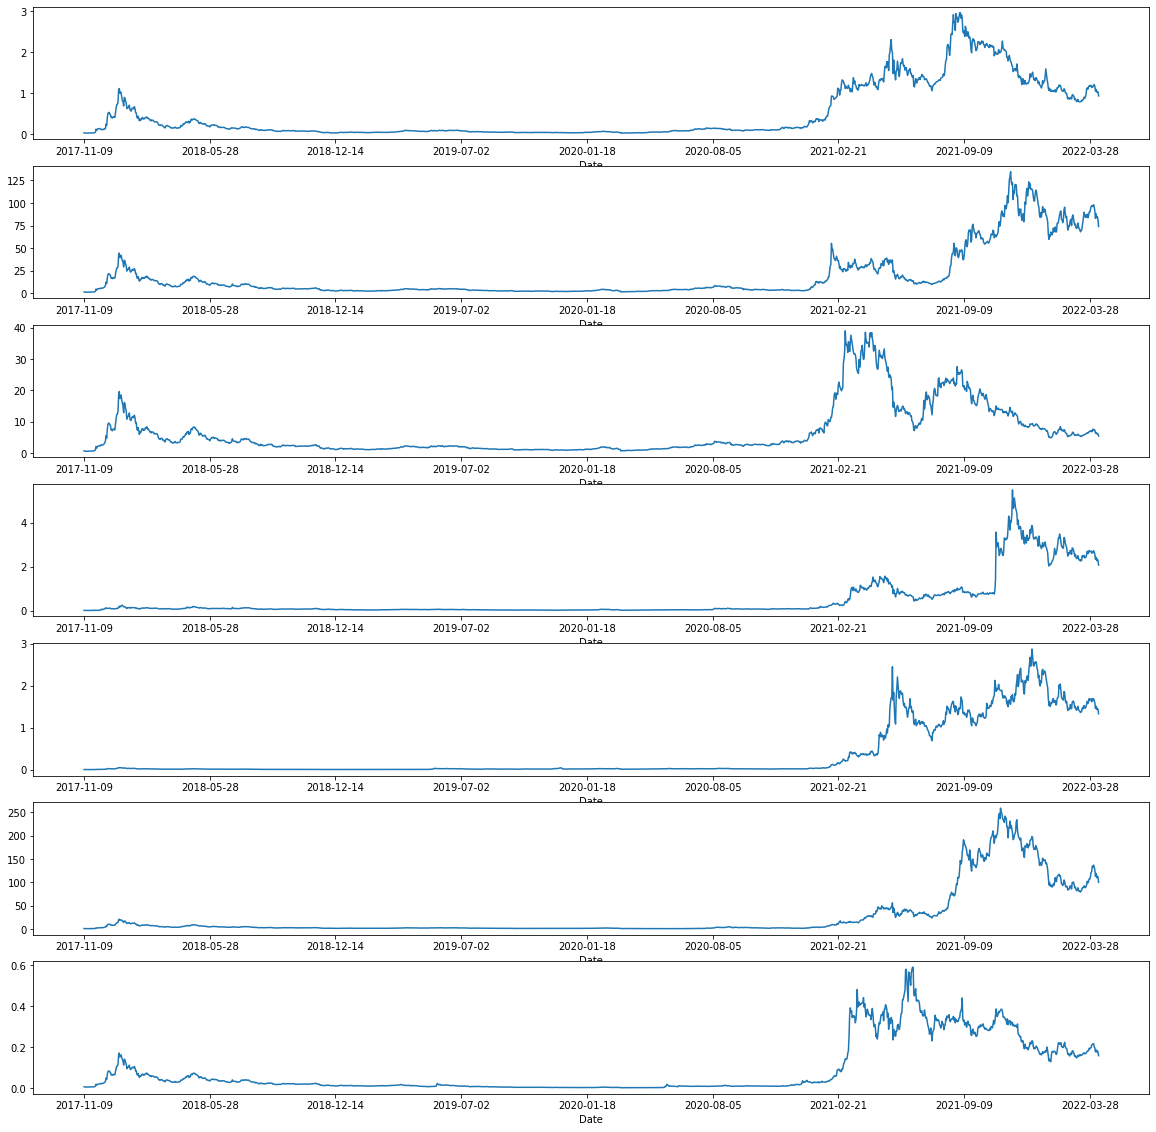

In [181]:
# .csvs downloaded from Yahoo Finance
path = "../data/instruments"
fig, ax = plt.subplots(7, figsize=(20,20))

ada_df = pd.read_csv("../data/instruments/ADA.csv")
dates = ada_df['Date']

mana_df = pd.read_csv("../data/instruments/MANA.csv")

ada_df['Open'] = np.mean((mana_df['Open'], ada_df['Open']), axis=0) 
ada_df['High'] = np.mean((mana_df['High'], ada_df['High']), axis=0)
ada_df['Low'] = np.mean((mana_df['Low'], ada_df['Low']), axis=0) 
ada_df['Close'] = np.mean((mana_df['Close'], ada_df['Close']), axis=0) 
ada_df['Volume'] = np.mean((mana_df['Volume'], ada_df['Volume']), axis=0)

i = 0
for fn in os.listdir(path):
    print(i, fn)
    df = pd.read_csv(os.path.join(path, fn))
    
    # simulating earlier data for those without
    df = df.set_index("Date")
    first_date = df.index[0]
    
    # first day percentages
    fd_perc = ada_df.iloc[0,1:]/ada_df[ada_df["Date"] ==first_date].iloc[0,1:]
    
    if first_date > ada_df['Date'][0]:
        fd = fd_perc*df.iloc[0, :]
        
        # inverse pctchange
        pctchg = ada_df.set_index("Date", drop=True).pct_change()
        inversed_pctchg = (1+pctchg).cumprod()*fd
        early_df = inversed_pctchg[inversed_pctchg.index < first_date]
        
        # replace first missing row
        early_df.iloc[0] = fd
        
        # concat early values
        concat = pd.concat((early_df[early_df.index < first_date], df))
        df = concat
        
    # plot
    _ = df['Close'].plot(ax=ax[i])    
    
    df.to_csv(os.path.join("../data/instruments_modified", fn))
    
    i += 1
    print(df.head())

## Creating a Bundle

In [182]:
# https://github.com/aspromatis/zipline_bundle/blob/master/prepare_bundle.py
# Assuming crypto

def format_bundle(indir, outdir):
       
    count = 0
    for f in os.listdir(indir): # For Production
    # for f in ['AAPL.csv']:  # For Testing
        if f[-4:] != '.csv':
            continue
        
        df = pd.read_csv(os.path.join(indir,f), index_col='Date')
        
        # trading days will be the same 
        #df = df.reindex(trading_days)

        # Export it in the csvdir format needed for the zipline bundle ingestion process
        df.reset_index(inplace=True)
        
        # drop adj close column
        df.drop('Adj Close', axis=1, inplace=True)
        
        # Check if there is there is any dividend, if not make it zero
        if not 'dividend' in df.columns:
            df['dividend'] = 0.0
        
        # Assume the only columns that exist in the .csv are [Date, Open, High, Low, Close, Adj Close, Volume] in that order
        #df = df[['date', 'open_adj', 'high_adj', 'low_adj', 'close_adj', 'volume_adj', 'dividend']]
        
        df['dividend'].fillna(0.00, inplace=True)
        df['ratio'] = 1  # There are no splits
        
        old_colnames = df.columns
        
        df.rename(columns={old_colnames[0]: 'date',
                           old_colnames[1]: 'open',
                           old_colnames[2]: 'high',
                           old_colnames[3]: 'low',
                           old_colnames[4]: 'close',
                           old_colnames[5]: 'volume'
                           }, inplace=True)
        
        # Round the numbers in the dataframe
        # won't work very well for small-cap coins?
        # could put off rounding?
        df = df.round({'open':6,
                  'high':6,
                  'low':6,
                  'close':6,
                  'volume':0,
                  'dividend':2})

        df.to_csv(os.path.join(outdir, f), index=False)

        count += 1
        
    return ('{} files were adjusted'.format(count))

# simulated early data
format_bundle("../data/instruments_modified", "../data/daily")

# non-simulated (mismatching date ranges)
#format_bundle("../data/instruments", "../data/daily")

'7 files were adjusted'